In [1]:
import os
import sys
import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
%matplotlib inline
# %matplotlib notebook

from glob import glob
timer = cy.timing.Timer()
time = timer.time

In [2]:
import SETTING
paths = SETTING.PATH()
print(paths)
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from utils import *


#### Working at GT ####

USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/version-002-p04
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output



In [3]:
tw_batchSize_map = {
                 10:10000,
                 25:1000,
                 50:1000,
                 100:100,
                 250:100,
                 500:100
                }

In [4]:
import argparse

######################### CONFIGURE ARGUEMENTS #############################
# p = argparse.ArgumentParser(description="Background Trials",
#                             formatter_class=argparse.RawTextHelpFormatter)
# p.add_argument("--grb_name", default="GRB190612A", type=str, help="Name of one GRB")
# p.add_argument("--batchNtrials", default=100, type=int, help="Number of trials in this batch")
# p.add_argument("--batchIndex", default=0, type=int, help="Index of current batch")
# p.add_argument("--tw_in_second", default=10, type=int, help="Length of the time window in seconds")
# p.add_argument("--concat", default=0, type=int, help="True(1) for the last batchIndex. used to clear up everything")
# p.add_argument("--totalNtrials", default=100000000, type=int, help="Number of total trials (1e8)")
# p.add_argument("--ncpu", default=1, type=int, help="Number of CPU to give Csky")
# p.add_argument("--mode", default="production", type=str, help="Mode: production or testing")
# args = p.parse_args()
###########################################################################

### testing on jupyter ###
class args:
    grb_name = "GRB180423A"    # real healpix example
    # grb_name = "GRB190611B"    # fake healpix example
    batchNtrials = 40
    batchIndex = 0
    tw_in_second = 500
    concat=0
    totalNtrials = 40
    ncpu = 4
    mode = "testing"
##########################

In [5]:
if tw_batchSize_map[args.tw_in_second] != args.batchNtrials and args.mode=="prodection":
    raise Exception("You are not using the recommended batchNtrials wrt this tw_in_second!")

In [6]:
print("\n===== Loading GRB list =====\n") 
if args.mode != "production":
    ANA_DIR = ANA_DIR + "/test"
# All times in days, all angles in degrees
try:
    df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHeaplix.pkl")
except:
    raise Exception("Cannot pd.reade_picle() the grbweb_gbm_noHeaplix.pkl.\n")

print("\n...Done\n")
print("\n===== Loading healpix of {}=====\n".format(args.grb_name))   
try:
    healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format(args.grb_name))
    # healpix can contain negative values: faults due to Fermi-GBM
    healpix = np.maximum(healpix,0)
    ########## healpix reduce ##########
    healpix[healpix <= isf_healpix(healpix, q=0.95)] = 0
except:
    raise Exception("Cannot load the healpix for grb: {}\n".format(args.grb_name))
    
grb_row = df.loc[df['grb_name'] == args.grb_name]
tw = args.tw_in_second/86400.
tw_start = grb_row.t_center - 0.5*tw
ra = grb_row.ra
dec = grb_row.dec
print("\n...Done\n")


===== Loading GRB list =====


...Done


===== Loading healpix of GRB180423A=====


...Done



In [7]:
print("\n===== Setting up csky =====\n")
data_dir = ICDATA_DIR
data_filenames = sorted(glob(data_dir + '/IC86_20*.data_with_angErr.npy'))
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged_with_angErr.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))

################ energy lower bound #############
min_log_e = np.log10(10)
#################################################
bins_sindec = np.linspace(-1, 1, 25+1)  
bins_logenergy = np.linspace(min_log_e, 5, 30+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
if min_log_e is not None:
    data_mask = data['logE'] > min_log_e
    data = data[data_mask]
    sig_mask = sig['logE'] > min_log_e
    sig = sig[sig_mask]
    
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.4', cascades=True)

ana_dir = cy.utils.ensure_dir(ANA_DIR)
ana = cy.get_analysis(cy.selections.repo, dataset_spec, dir=ana_dir, load_sig=True)    



===== Setting up csky =====

Setting up Analysis for:
greco_v2.4
Setting up greco_v2.4...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [8]:
conf = {
    'ana': ana,
    #### llh basics: csky.conf
    'space': 'ps', # ps/fitps/template/prior
    'time': 'transient', # utf/lc/transient
    'energy': 'customflux', # fit/customflux
    'flux': cy.hyp.PowerLawFlux(2),
    #### inj.py - prior has some duplications against space's prior
    'sig': 'transient', # ps/tw/lc/transient/template/prior
    'full_sky': True,
    'extended': True,
    'mp_cpus': args.ncpu
    }

cy.CONF.update(conf)

In [9]:
cy.CONF

{'mp_cpus': 4,
 'ana': Analysis(keys=[greco_v2.4]),
 'space': 'ps',
 'time': 'transient',
 'energy': 'customflux',
 'flux': PowerLawFlux(gamma=2),
 'sig': 'transient',
 'full_sky': True,
 'extended': True}

In [10]:
print("\n===== Generating seeds for current batch =====\n")   
src = cy.utils.Sources(
    ra=ra,
    dec=dec,
    deg=True,
    mjd=tw_start, 
    sigma_t=np.zeros_like(tw), 
    t_100=tw,  # in days
    prior=[hl.heal.HealHist(healpix)],
    name=args.grb_name
)

sptr = cy.get_spatial_prior_trial_runner(conf=cy.CONF
                                         ,src_tr=src
                                         ,llh_priors=[healpix]
                                         ,cut_n_sigma=5.) # src_tr is must for transient

rng=np.random.default_rng(abs(java_hash(src.name[0])))
seeds = rng.integers(int(1e9), size=int(2e8))[args.batchNtrials*args.batchIndex: args.batchNtrials*(args.batchIndex + 1)]
print("\n...Done\n")


===== Generating seeds for current batch =====


...Done



In [11]:
print("\n===== Getting fits =====\n")   
fits = []
with time('fits from n_trials'):
    for no_trial, seed in enumerate(seeds):
        if no_trial % (len(seeds) // 10) == 0:
            print("Working on no_trial: {} \n".format(no_trial))
#         old_stdout = sys.stdout # suppress output start
#         sys.stdout = open(os.devnull, "w")
        fit = sptr.get_one_fit(
            0,
            seed=seed,
            TRUTH=False, 
            logging=False,
            mp_cpus=args.ncpu
        )
#         sys.stdout = old_stdout # suppress output end
        if fit[0] == 0:
            fit.fill(np.nan)
        fits.append(fit)
print("\n...Done\n")  


===== Getting fits =====

Working on no_trial: 0 

Working on no_trial: 4 

Working on no_trial: 8 

Working on no_trial: 12 

Working on no_trial: 16 

Working on no_trial: 20 

Working on no_trial: 24 

Working on no_trial: 28 

Working on no_trial: 32 

Working on no_trial: 36 


0:01:19.786553 elapsed.

...Done



In [12]:
np.sum(healpix > 0) / len(healpix)

0.01361083984375

In [14]:
1*60 + 19

79

In [23]:
np.mean(df.t100 * 86400)

47.92039054119943

In [17]:
fits_df = pd.DataFrame(fits[:,1:], columns=['TS', 'ns', 'ra', 'dec'])
sfits_df = fits_df.astype(pd.SparseDtype("float", np.nan))

In [14]:
fits_df = pd.DataFrame(fits, columns=['TS', 'ns', 'ra', 'dec'])
sfits_df = fits_df.astype(pd.SparseDtype("float", 0.0))
output_folder = cy.utils.ensure_dir(ANA_DIR+"/bg_trials/{}/tw{}".format(args.grb_name, args.tw_in_second))
sfits_df.to_pickle(
    output_folder+"/{}_batchSize{}_batchIndex{}_tw{}.npz".format(args.grb_name, 
                                                                args.batchNtrials, 
                                                                args.batchIndex, 
                                                                args.tw_in_second))




In [51]:
if args.concat and args.batchIndex * args.batchNtrials == args.totalNtrials:
    print("\n===== Concatenating {} tw{} =====\n".format(args.grb_name, args.tw_in_second))
    import time
    files = []
    cnt = 0
    do_concat = False
    while True:
        files = glob(output_folder + "{}_batchSize{}_batchIndex*_tw{}.pkl".format(
            args.grb_name, 
            args.batchNtrials, 
            args.tw_in_second
        ))
        if len(files) == args.batchIndex + 1:
            do_concat = True
            break
        time.sleep(180)
        cnt += 1
        if cnt > 10: 
            break
    if do_concat:
        files = sorted(files)
        df_list = [pd.read_pickle(x) for x in files]
        out_df = pd.concat(df_list)
        sout_df = out_df.astype(pd.SparseDtype("float", 0.0))
        try:
            sout_df.to_pickle(output_folder+"/{}_totalSize{}_tw{}.pkl".format(args.grb_name, 
                                                                                args.totalNtrials, 
                                                                                args.tw_in_second))
            os.system("rm {}/*_batchSize*.pkl".format(output_folder))
        except:
            raise Exception("cannot save sparse concatenated pickle or cannot rm batch pickles.")


In [23]:
output_folder = cy.utils.ensure_dir(ANA_DIR+"/bg_trials/{}/tw{}".format(args.grb_name, args.tw_in_second))


files = glob(output_folder + "/{}_batchSize{}_batchIndex*_tw{}.pkl".format(
            args.grb_name, 
            args.batchNtrials, 
            args.tw_in_second
        ))

In [57]:
df_list = []
df_list.append(sfits_df)
df_list.append(fits_df)


In [30]:
sout_df = out_df.astype(pd.SparseDtype("float", 0.0))
        

In [33]:
# sout_df.to_pickle(output_folder+"/{}_totalSize{}_tw{}.pkl".format(args.grb_name, 
#                                                                                 args.totalNtrials, 
#                                                                                 args.tw_in_second))
            

In [35]:
# os.system("rm {}/*_batchSize*.pkl".format(output_folder))

0

In [39]:
df.head()

,grb_name,grb_name_GBM,ra,dec,mjd_start,t100,t90,gbm,source_uncertainty,redshift,t_center,hasHealpix
0,GRB190613B,GRB190613449,305.431917,-4.646667,58647.449285,0.001905,0.000056,0,0.000056,NaN,58647.450238,True
1,GRB190613A,GRB190613172,182.529208,67.235278,58647.171736,0.000204,0.000198,0,0.000056,NaN,58647.171838,True
2,GRB190612A,GRB190612165,223.950000,62.100000,58646.164836,0.001677,0.001677,1,7.025096,NaN,58646.165675,True
3,GRB190611B,GRB190611950,84.758333,50.833333,58645.949833,0.001217,0.001164,0,5.900000,NaN,58645.950442,True
4,GRB190611A,None,324.722625,-56.074278,58645.742373,0.000484,0.000484,0,0.000194,NaN,58645.742615,False


In [24]:
import time
cnt = 0
while True:
    cnt += 1
    print(cnt)
    time.sleep(180)

1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

In [2]:
import numpy as np
nt=100
tw = np.r_[1,2,5,10,20,50,100,200,500,1000,2000,5000]
la = tw * 0.004
r = 1- np.exp(-la)
nt * r

array([ 0.39920107,  0.79680852,  1.98013267,  3.92105608,  7.68836536,
       18.12692469, 32.9679954 , 55.06710359, 86.46647168, 98.16843611,
       99.96645374, 99.99999979])

In [234]:
def getBkgTS(grb_idx=0, tw_in_second=10, n_trials=1e2):
    
    
    idx = grb_idx;
    tw_in_second = 1.0*tw_in_second

    name = df.grb_name[idx]
    ra = df.ra[idx]
    dec = df.dec[idx]
    tw_start = df.mjd_start[idx] + 0.5*(df.t100[idx] - tw_in_second/86400.)
    tw = tw_in_second/86400.
    healpix = df.probs[idx]

    src = cy.utils.Sources(
        ra=ra,
        dec=dec,
        deg=True,
        mjd=tw_start, 
        sigma_t=np.zeros_like(tw), 
        t_100=tw,  # in days
        prior=[hl.heal.HealHist(healpix)],
        name=name
    )
    
    rng=np.random.default_rng(int(src.name[0][3:-1]))
    seeds = rng.integers(1e9, size=int(n_trials))
    fits = []
    with time('fits from n_trials'):
        for no_trial, seed in enumerate(seeds):
            if no_trial % 100 == 0:
                print("Working on no_trial: {} \n".format(no_trial))
            bg_trial = tr.get_one_trial(0, seed=seed)
            fit = tr.get_one_fit_from_trial(
                bg_trial, 
                TRUTH=False, 
                logging=False
            )
            fits.append(fit)
            
    return fits

In [239]:
fits = getBkgTS(grb_idx=340, tw_in_second=10, n_trials=1e3)

Working on no_trial: 0 

Scanning 98079 locations using 4 cores:
      98079/98079 coordinates complete.   
Scanning 21541 locations using 4 cores:
      21541/21541 coordinates complete.   
Scanning 178522 locations using 4 cores:
     178522/178522 coordinates complete.   
Scanning 187363 locations using 4 cores:
     187363/187363 coordinates complete.   
Working on no_trial: 100 

Scanning 168530 locations using 4 cores:
     168530/168530 coordinates complete.   
Scanning 171855 locations using 4 cores:
     171855/171855 coordinates complete.   
Scanning 187363 locations using 4 cores:
     187363/187363 coordinates complete.   
Scanning 187181 locations using 4 cores:
     187181/187181 coordinates complete.   
Scanning 187363 locations using 4 cores:
     187363/187363 coordinates complete.   
Scanning 96794 locations using 4 cores:
      96794/96794 coordinates complete.   
Scanning 105242 locations using 4 cores:
     105242/105242 coordinates complete.   
Scanning 187363 loc

In [240]:
from copy import deepcopy
fits_copy=deepcopy(fits)
fits_df = pd.DataFrame(fits_copy, columns=['TS', 'ns'])
# fits_df.to_pickle("/home/cjchen/2020-2021/Spring2021/greco_grb/data/test/id{}_n{}_tw{:.2f}.pkl".format(340, int(1e3), 10))



<IPython.core.display.Javascript object>


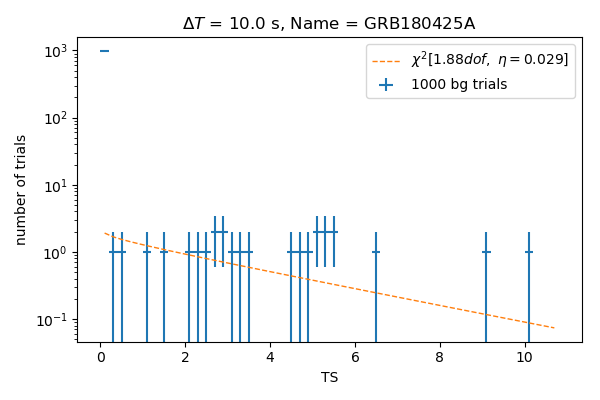

In [243]:
fits_df = pd.read_pickle("/home/cjchen/2020-2021/Spring2021/greco_grb/data/test/id{}_n{}_tw{:.2f}.pkl".format(340, int(1e3), 10))
bg=cy.dists.Chi2TSD(fits_df.TS)

fig, ax = plt.subplots(dpi=100)
h = bg.get_hist(bins=np.r_[0:11:0.2])
hl.plot1d(ax, h, crosses=True, label='{} bg trials'.format(bg.n_total))
# compare with the chi2 fit:
x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
            label=r'$\chi^2[{:.2f} dof,\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

ax.set_title('$\Delta T$ = {} s, Name = {}'.format(tw_in_second, df.grb_name[340]))
ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
plt.tight_layout()

## GRB120427B, real healpix

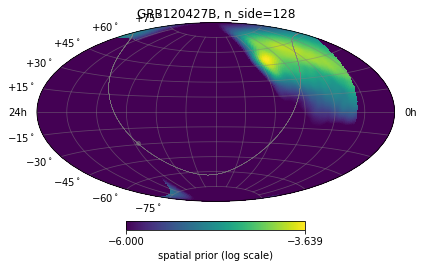

In [35]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix.npy".format("GRB120427B"))
healpix
test128 = np.maximum(healpix, 1e-6)
fig, ax = plt.subplots (subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.log10(test128), n_ticks=2)
kw = dict(color='.5', alpha=.5)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'spatial prior (log scale)')
plt.title("GRB120427B, n_side=128")
plt.tight_layout()

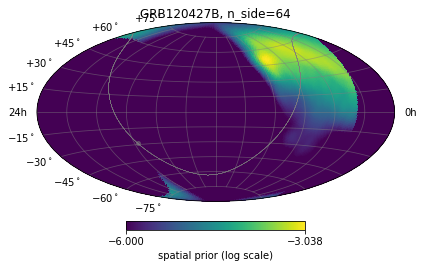

In [36]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB120427B"))
healpix
test64 = np.maximum(healpix, 1e-6)
fig, ax = plt.subplots (subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.log10(test64), n_ticks=2)
kw = dict(color='.5', alpha=.5)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'spatial prior (log scale)')
plt.title("GRB120427B, n_side=64")
plt.tight_layout()


In [61]:
files = glob("/storage/home/hhive1/cchen641/icecube/greco_grb/data/csky_output/test/bg_trials/GRB120427B/tw5/*")
files
df_list = [pd.read_pickle(x) for x in files]
df = pd.concat(df_list)
np.sum(np.array(df.TS) > 0) / 200

0.01

In [62]:
files = glob("/storage/home/hhive1/cchen641/icecube/greco_grb/data/csky_output/test/bg_trials/GRB120427B/tw50/*")
files
df_list = [pd.read_pickle(x) for x in files]
df = pd.concat(df_list)
np.sum(np.array(df.TS) > 0) / 200

0.055

In [63]:
files = glob("/storage/home/hhive1/cchen641/icecube/greco_grb/data/csky_output/test/bg_trials/GRB120427B/tw500/*")
files
df_list = [pd.read_pickle(x) for x in files]
df = pd.concat(df_list)
np.sum(np.array(df.TS) > 0) / 200

0.145

In [64]:
files = glob("/storage/home/hhive1/cchen641/icecube/greco_grb/data/csky_output/test/bg_trials/GRB120427B/tw5000/*")
files
df_list = [pd.read_pickle(x) for x in files]
df = pd.concat(df_list)
np.sum(np.array(df.TS) > 0) / 200

0.315

## GRB190611B, fake healpix

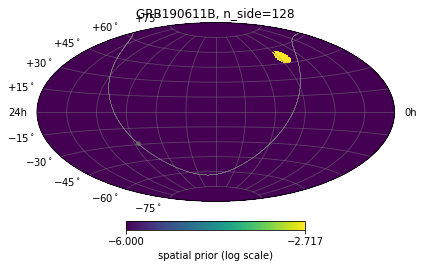

In [38]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix.npy".format("GRB190611B"))
healpix
test128 = np.maximum(healpix, 1e-6)
fig, ax = plt.subplots (subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.log10(test128), n_ticks=2)
kw = dict(color='.5', alpha=.5)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'spatial prior (log scale)')
plt.title("GRB190611B, n_side=128")
plt.tight_layout()

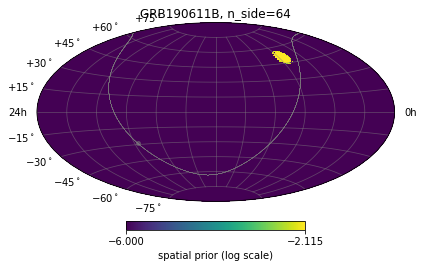

In [39]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB190611B"))
healpix
test64 = np.maximum(healpix, 1e-6)
fig, ax = plt.subplots (subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.log10(test64), n_ticks=2)
kw = dict(color='.5', alpha=.5)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'spatial prior (log scale)')
plt.title("GRB190611B, n_side=64")
plt.tight_layout()



In [65]:
files = glob("/storage/home/hhive1/cchen641/icecube/greco_grb/data/csky_output/test/bg_trials/GRB190611B/tw5/*batchSize1000*")
files
df_list = [pd.read_pickle(x) for x in files]
df = pd.concat(df_list)
np.sum(np.array(df.TS) > 0) / 2000

0.011

In [66]:
files = glob("/storage/home/hhive1/cchen641/icecube/greco_grb/data/csky_output/test/bg_trials/GRB190611B/tw50/*batchSize1000*")
files
df_list = [pd.read_pickle(x) for x in files]
df = pd.concat(df_list)
np.sum(np.array(df.TS) > 0) / 2000

0.053

In [67]:
files = glob("/storage/home/hhive1/cchen641/icecube/greco_grb/data/csky_output/test/bg_trials/GRB190611B/tw500/*batchSize1000*")
files
df_list = [pd.read_pickle(x) for x in files]
df = pd.concat(df_list)
np.sum(np.array(df.TS) > 0) / 2000

0.123

In [68]:
files = glob("/storage/home/hhive1/cchen641/icecube/greco_grb/data/csky_output/test/bg_trials/GRB190611B/tw5000/*batchSize1000*")
files
df_list = [pd.read_pickle(x) for x in files]
df = pd.concat(df_list)
np.sum(np.array(df.TS) > 0) / 2000

0.2395

In [69]:
hp.nside2npix(128), hp.nside2npix(64)

(196608, 49152)

In [75]:
np.rad2deg(hp.nside2resol(128)), np.rad2deg(hp.nside2resol(64))

(0.45806485490898746, 0.9161297098179749)

Text(0.5, 0, 'Time Window')

<Figure size 432x288 with 0 Axes>

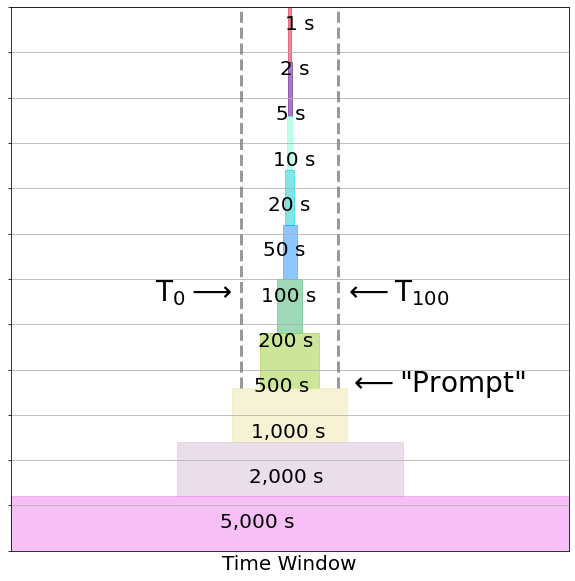

In [149]:
###
### Cartoon of time windows with T0 and T100 dashed lines
###
t100_start = 58231.03258640
t100_stop = 58231.0332114
start = t100_start
stop = t100_stop
tw = [1.,2.,5.,10., 20., 50., 100., 200., 500., 1000.,2000, 5000.]         # Seconds --> 200000., 2000000.
time_windows = [i/2./86400. for i in tw]
plt.figure()
t_center = start + (stop-start)/2
ea = [0.001, 0.0015, 0.0018, 0.002, 0.0025, 0.003, 0.003, 0.003, 0.0035, 0.0035, 0.0035, 0.009, 0.02] # ea = extra adjustment
ea2 = [0., 0., 0.,0., 0., 0., 0., 0., 0., 0., 0., 0., 0.0] # ea2 = extra adjustment 2

true_time_windows = ['1 s', '2 s', '5 s', '10 s', '20 s', '50 s', '100 s', '200 s', '500 s', '1,000 s', '2,000 s', '5,000 s']
new_time_windows = [1.,2.,5.,10., 20., 50., 100., 200., 500., 1000.,2000, 5000.]
plot_time_windows = [i/86400. for i in new_time_windows]
color_list = ['thistle', 'violet', 'crimson', 'indigo', 'aquamarine',
          'darkturquoise',  'dodgerblue', 'mediumseagreen', 'yellowgreen', 'palegoldenrod','thistle', 'violet', 'crimson']
plt.figure(figsize=(10,10))
for i in range(len(plot_time_windows)):
    startTW = start-plot_time_windows[i]+ea2[i]
    stopTW = stop+plot_time_windows[i]
    center = (stopTW-startTW)/2.
    tw_duration = time_windows[i]*2. + (stop-start)
    plt.axvspan(startTW, stopTW, ymin=1.2-0.1*(i+1), ymax=1.2-0.1*(i), alpha=0.5, color=color_list[i])
    plt.text(startTW+center-0.0005*i-ea[i], 1.2-0.1*(i+0.5), true_time_windows[i], fontsize=20)

plt.axvline(t_center-0.01, 0.3, 1.2, linestyle='--', color='grey', alpha=0.8, linewidth=3)
plt.axvline(t_center+0.01, 0.3, 1.2, linestyle='--', color='grey', alpha=0.8, linewidth=3)
plt.text(t_center-0.028, 0.55, r'T$_{0}\longrightarrow$', fontsize=28)
plt.text(t_center+0.011, 0.55, r'$\longleftarrow$T$_{100}$', fontsize=28)
plt.text(t_center+0.012, 0.35, r'$\longleftarrow$"Prompt"', fontsize=28)
# plt.text(t_center-0.035, 0.05, '-1 Day', fontsize=20)
# plt.text(t_center-0.035, 0.15, '-1 Day', fontsize=20)
# plt.text(t_center+0.035, 0.05, '+14 Days', fontsize=20)
# plt.text(t_center+0.035, 0.15, '+1 Day', fontsize=20)

#plt.text(t_center-0.05, 0.82, 'IceCube \nPreliminary', color='r', fontsize=28)

plt.xscale('log')
plt.xlim(t_center-plot_time_windows[-1], t_center+plot_time_windows[-1])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.yticks(np.r_[0:1.3:0.1], [])
# plt.ylim(0, 1.2)
plt.grid(True)
plt.xlabel('Time Window', fontsize=20)
# plt.title('Size of Time Window', fontsize=28)

/usr/local/pace-apps/manual/packages/anaconda3/2020.02/lib/python3.7/site-packages/ipykernel/__main__.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/healpy/projaxes.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds
/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interv

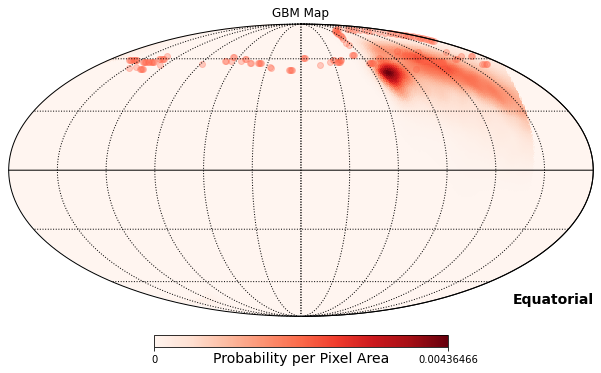

In [18]:
healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format("GRB120427B"))
probs_copy = np.sort(probs)
cdf = np.cumsum(probs_copy)
probs90 = probs_copy[(np.abs(cdf - 0.1)).argmin()]
cmap = cm.Reds
cmap.set_under("w")

# pixels = np.where((0 != probs) & (9.5e-7 < probs) & (probs < 1e-6))[0]  # Get the circle around the GBM burst
pixels = np.where((probs > 0.95*probs90) & (probs < 1.05*probs90))[0]

THETA, PHI = hp.pixelfunc.pix2ang(128, pixels)  # Get all the angles for this circle
pixarea = hp.pixelfunc.nside2pixarea(128, degrees=True)
hp.mollview(probs/pixarea, cbar=True, coord='C',unit=r'Probability per Pixel Area',rot=180, cmap=cmap, min=0, max=np.max(probs/pixarea), title='GBM Map')
hp.graticule()

hp.projscatter(THETA, PHI, color='tomato', alpha=0.3)




In [11]:
grbweb = pd.read_pickle("/home/cjchen/2020-2021/Spring2021/greco_grb/data/grbweb/grb_grbweb.pkl")
# probs = hp.read_map("/home/cjchen/2020-2021/Spring2021/greco_grb/data/gbm/healpix/glg_healpix_all_bn120426585_v00.fit")
# grbweb.loc[grbweb['grb_name_GBM'] == "GRB120426585"]

probs = hp.read_map("/home/cjchen/2020-2021/Spring2021/greco_grb/data/gbm/healpix/glg_healpix_all_bn180423033_v00.fit")
grbweb.loc[grbweb['grb_name_GBM'] == "GRB180423033"]


FileNotFoundError: [Errno 2] No such file or directory: '/home/cjchen/2020-2021/Spring2021/greco_grb/data/grbweb/grb_grbweb.pkl'

In [12]:
probs_copy = np.sort(probs)
cdf = np.cumsum(probs_copy)
probs90 = probs_copy[(np.abs(cdf - 0.1)).argmin()]

NameError: name 'probs' is not defined

In [13]:
cmap = cm.Reds
cmap.set_under("w")

# pixels = np.where((0 != probs) & (9.5e-7 < probs) & (probs < 1e-6))[0]  # Get the circle around the GBM burst
pixels = np.where((probs > 0.95*probs90) & (probs < 1.05*probs90))[0]

THETA, PHI = hp.pixelfunc.pix2ang(128, pixels)  # Get all the angles for this circle
pixarea = hp.pixelfunc.nside2pixarea(128, degrees=True)
hp.mollview(probs/pixarea, cbar=True, coord='C',unit=r'Probability per Pixel Area',rot=180, cmap=cmap, min=0, max=np.max(probs/pixarea), title='GBM Map')
hp.graticule()

hp.projscatter(THETA, PHI, color='tomato', alpha=0.3)


/usr/local/pace-apps/manual/packages/anaconda3/2020.02/lib/python3.7/site-packages/ipykernel/__main__.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  from ipykernel import kernelapp as app


NameError: name 'probs' is not defined

In [ ]:
src = cy.S

In [230]:
np.rad2deg(hp.nside2resol(128)),hp.nside2pixarea(128, degrees=True)**0.5

(0.45806485490898746, 0.4580648549089874)

In [229]:
np.rad2deg(hp.nside2resol(64)), hp.nside2pixarea(64, degrees=True)**0.5

(0.9161297098179749, 0.9161297098179748)

In [244]:
hp.nside2npix(128), hp.nside2npix(64)

(196608, 49152)

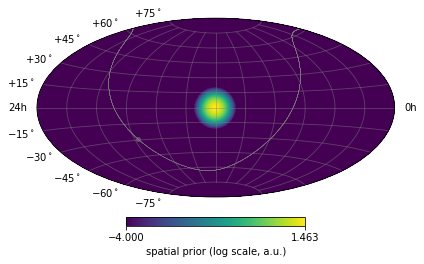

In [9]:
m = hl.heal.hist(128, [0], [np.pi]).smoothing(np.radians(10)).normalize()
m.map = np.maximum(1e-4, m.map)
fig, ax = plt.subplots (subplot_kw=dict (projection='aitoff'))
sp = cy.plotting.SkyPlotter(pc_kw=dict())
mesh, cb = sp.plot_map(ax, np.log10(m.map), n_ticks=2)
kw = dict(color='.5', alpha=.5)
sp.plot_gp(ax, lw=.5, **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
cb.set_label(r'spatial prior (log scale, a.u.)')
plt.tight_layout()

In [6]:
ra = grbweb.loc[grbweb['grb_name_GBM'] == "GRB180423033"].ra
dec = grbweb.loc[grbweb['grb_name_GBM'] == "GRB180423033"].dec
mjd = grbweb.loc[grbweb['grb_name_GBM'] == "GRB180423033"].mjd_start
mjd

NameError: name 'grbweb' is not defined

In [ ]:
np.sum(m.map)